# In-vivo evidence for increased tau deposition in temporal lobe epilepsy

# Supplementary Figure: Sex analysis


In [1]:
# Libraries
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from brainspace.plotting import plot_hemispheres
from osfclient import OSF

# Load utilities functions from utils.py
from utils import *

### Fetch data

In [2]:
osf_path="/Users/rcruces/Desktop/OSF_data_revision-2025"

# Load the data frame
#osf_df = osf_download("18F-MK6240_in-vivo_database.csv", project_id='ct3gw')
#df = pd.read_csv(osf_df)
df = pd.read_csv(f"{osf_path}/18F-MK6240_in-vivo_database_osf.csv")

# Load processed 18F-MK6240 PET data | matrix:{vertices x subjects}
#osf_pet_raw = osf_download("surf-fsLR-32k_desc-GroupData_smooth-10mm_pvc-probGM_ref-cerebellarGM_trc-18Fmk6240_pet.npy", project_id='ct3gw')
#pet_raw = np.load(osf_pet_raw)
pet_raw = np.load(f"{osf_path}/surf-fsLR-32k_desc-GroupData_smooth-10mm_pvc-probGM_ref-cerebellarGM_trc-18Fmk6240_pet.npy")

# Load fsLR-32 surface
fslr32k_lh = fetch_surface('fsLR-32k.L.surf.gii')
fslr32k_rh = fetch_surface('fsLR-32k.R.surf.gii')
fslr32k = fetch_template_surface("fslr32k", join=True)

# Load fsLR-32k middle wall mask
fslr32k_mask = fetch_mask("fslr32k")

### Sort the matrices into ipsilateral/contralateral relative to seizure focus

In [3]:
# fsLR-32k length
n_64k = pet_raw.shape[1]
n_32k = int(n_64k/2)

# Flip R >> L 18F-mk6240
mk_ipsi, mk_contra = flip_mat(pet_raw[:,0:n_32k], pet_raw[:,n_32k:n_64k], df['lateralization'].values, flip='R')

# Merge ipsi and contra
tauMK6240 = np.concatenate((mk_ipsi, mk_contra), axis=1)


Flipping data from Right to Left


# Sex analysis

In [4]:

def plot_mk6240_group_summary_by_sex(slm, mk_matched, df, threshold=0.01):
    """
    Compute and plot group-level MK6240 SUVR summary divided by sex
    for ipsilateral and contralateral hemispheres.

    Parameters:
        slm: Statistical Linear Model object containing p-values under slm.P["pval"]["C"]
        mk_matched: np.ndarray of shape (n_subjects, n_vertices), matched SUVR values
        df: pandas DataFrame with 'group' and 'sex' columns
        threshold: float, significance threshold for p-values (default: 0.01)
    """

    # Copy p-values and define hemispheric split
    pvalues = np.copy(slm.P["pval"]["C"])
    n_64k = mk_matched.shape[1]
    n_32k = n_64k // 2

    mk_ipsi = mk_matched[:, :n_32k]
    mk_contra = mk_matched[:, n_32k:]

    # Binarize significant vertices
    pvalues_bin = (pvalues < threshold).astype(int)
    pvalues_bin_ipsi = pvalues_bin[:n_32k]
    pvalues_bin_contra = pvalues_bin[n_32k:]

    # Compute mean SUVR for significant and all vertices
    df = df.copy()  # avoid modifying original
    df['mk6240.sig.ipsi'] = np.mean(mk_ipsi[:, pvalues_bin_ipsi == 1], axis=1)
    df['mk6240.sig.contra'] = np.mean(mk_contra[:, pvalues_bin_contra == 1], axis=1)
    df['mk6240.mean.ipsi'] = np.mean(mk_ipsi, axis=1)
    df['mk6240.mean.contra'] = np.mean(mk_contra, axis=1)

    # Create combined group-sex label
    df['group_sex'] = df['group'] + "-" + df['sex']

    # Define plotting order
    order = ["Healthy-F", "Healthy-M", "Patient-F", "Patient-M"]
    palette = {
        "Healthy-F": "#666666",
        "Healthy-M": "#999999",
        "Patient-F": "#ff7777",
        "Patient-M": "#ff4444"
    }

    features = ['mk6240.sig.ipsi', 'mk6240.sig.contra']
    titles = ['Ipsilateral', 'Contralateral']

    ymin = df[features].min().min()
    ymax = df[features].max().max()
    buffer = (ymax - ymin) * 0.05

    plt.figure(figsize=(10, 3))

    for i, (feature, title) in enumerate(zip(features, titles), 1):
        plt.subplot(1, 2, i)

        sns.stripplot(
            data=df,
            x='group_sex',
            y=feature,
            order=order,
            hue='group_sex',
            palette=palette,
            alpha=0.6,
            jitter=True,
            dodge=False
        )

        # Overlay mean ± SD per group
        for x_pos, label in enumerate(order):
            group_data = df[df['group_sex'] == label][feature]
            if len(group_data) > 0:
                mean_val = group_data.mean()
                std_val = group_data.std()
                plt.plot(x_pos, mean_val, 'o', color='black')
                plt.vlines(x=x_pos, ymin=mean_val - std_val, ymax=mean_val + std_val,
                           color='black', linewidth=2)

        plt.title(title, fontsize=13)
        plt.xlabel('')
        plt.ylabel('SUVR')
        plt.ylim(ymin - buffer, ymax + buffer)
        plt.xticks(rotation=25)
        sns.despine()

    plt.tight_layout()
    plt.show()


In [5]:
# Cross-tabulation with rows = sex (M/F), columns = (group, mk6240.session)
cross_tab = pd.crosstab(
    index=df['sex'],
    columns=[df['group'], df['mk6240.session']],
    margins=False
)

# Display
display(cross_tab)

group          Healthy    Patient   
mk6240.session       1  2       1  2
sex                                 
F                   14  2      14  4
M                   14  5      14  9

# Females only

Y ~ group + age + sex + 1/subject


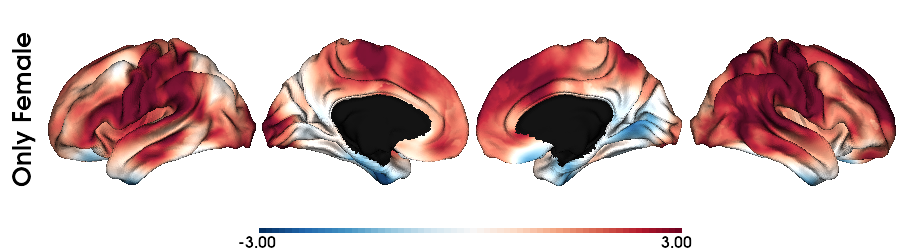

In [6]:
# Slice data
indx = df['sex'] == 'F'

# p>0.025 CREATE the mixed effects model
slm = mem_groups(Data=tauMK6240[indx,:], df=df[indx], Surf=fslr32k, mask=fslr32k_mask, Cthr=0.01, mem=True,  Pcorr="rft")

# Plot t-values
plot_ctx_slm(fslr32k_lh, fslr32k_rh, slm, color_range=(-3,3), Str='Only Female', Save=False, Col="RdBu_r", mask=fslr32k_mask,
            png_file='/home/bic/rcruces/Desktop/mk6240_tval.png', scale=1 )


# Males only

Y ~ group + age + sex + 1/subject


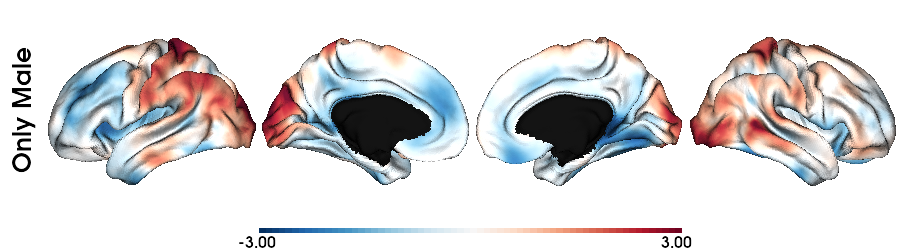

In [7]:
# Slice data
indx = df['sex'] == 'M'

# p>0.025 CREATE the mixed effects model
slm = mem_groups(Data=tauMK6240[indx,:], df=df[indx], Surf=fslr32k, mask=fslr32k_mask, Cthr=0.1, mem=True,  Pcorr="rft")

# Plot t-values
plot_ctx_slm(fslr32k_lh, fslr32k_rh, slm, color_range=(-3,3), Str='Only Male', Save=False, Col="RdBu_r", mask=fslr32k_mask,
            png_file='/home/bic/rcruces/Desktop/mk6240_tval.png', scale=1 )


## Interaction: difference in group effect (Female > Male)

Y ~ group + sex + group:sex + age + 1/subject
Y ~ group + sex + group:sex + age + 1/subject


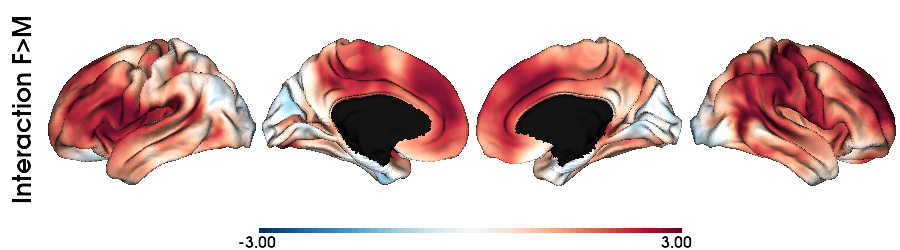

In [8]:
# Set the terms of the model
term_grp = FixedEffect(df['group'])
term_age = FixedEffect(df['age'])
term_sex = FixedEffect(df['sex'])
term_subject = MixedEffect(df['participant_id'])

# boolean masks
is_healthy = (df.group == 'Healthy')
is_patient = (df.group == 'Patient')
is_male = (df.sex == 'M')
is_female = (df.sex == 'F')

# Model is is mixed Subject is set as random Mixed effect variable
print("Y ~ group + sex + group:sex + age + 1/subject")
model = term_grp + term_sex + term_grp*term_sex + term_age  + term_subject

# Group effect IN MALES  -> (Healthy_male) - (Patient_male)
contrast_group_male = (is_patient & is_male).astype(int) - (is_healthy & is_male).astype(int)


# Group effect IN FEMALES -> (Healthy_female) - (Patient_female)
contrast_group_female = (is_patient & is_female).astype(int) - (is_healthy & is_female).astype(int)

# Interaction: difference in group effect (Female minus Male)
contrast_interaction = contrast_group_female - contrast_group_male

# Model is is mixed Subject is set as random Mixed effect variable
print("Y ~ group + sex + group:sex + age + 1/subject")
model = term_grp + term_sex + term_grp*term_sex + term_age  + term_subject

# fitting the model
slm_mixed = SLM(
        model,
        contrast_interaction,
        mask=fslr32k_mask,
        surf=fslr32k,
        correction="rft",
        two_tailed=True,
        cluster_threshold=0.01
    )
slm_mixed.fit(tauMK6240)

# Plot t-values
plot_ctx_slm(fslr32k_lh, fslr32k_rh, slm_mixed, color_range=(-3,3), Str='Interaction F>M', Save=False, Col="RdBu_r", mask=fslr32k_mask, scale=1 )



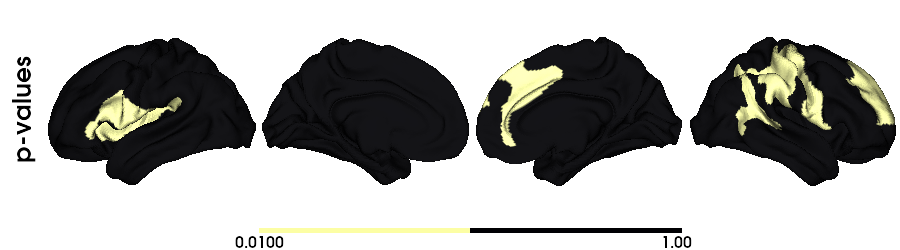

In [9]:
# p>0.025 Plot P-values
plot_ctx_pval(fslr32k_lh, fslr32k_rh, slm_mixed, Str='p-values', Col="inferno_r", Thr=0.01, scale=1)


## Mean MK6240 SUVR of significant areas by group and sex

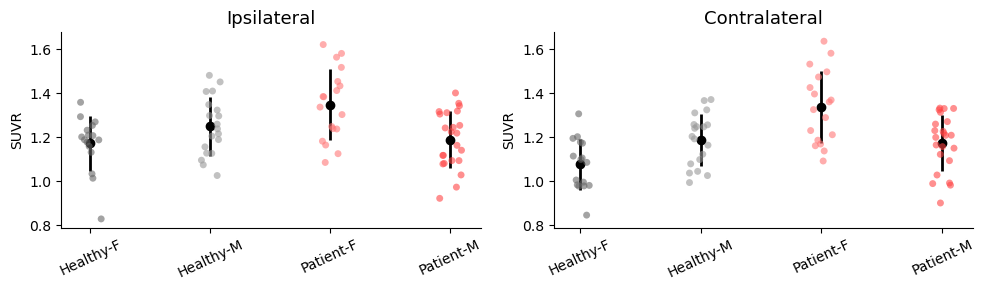

In [10]:
plot_mk6240_group_summary_by_sex(slm_mixed, tauMK6240, df, threshold=0.01)

## Mean MK6240 SUVR of significant areas by group only Females

Ipsilateral t-test: t=3.577, p=0.001147
Contralateral t-test: t=5.379, p=7.458e-06


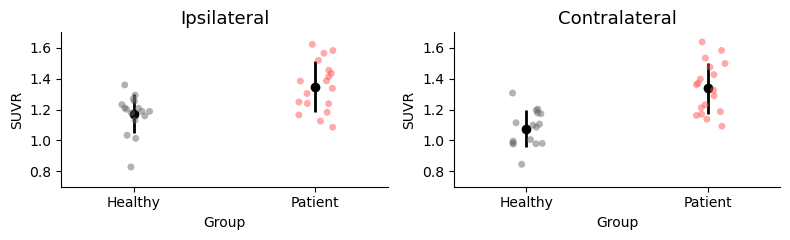

In [11]:
plot_mk6240_group_summary(slm_mixed, tauMK6240[df['sex'] == 'F',:], df[df['sex'] == 'F'], threshold=0.01)

## Mean MK6240 SUVR of significant areas by group only Males

Ipsilateral t-test: t=-1.479, p=0.1473
Contralateral t-test: t=-0.351, p=0.7277


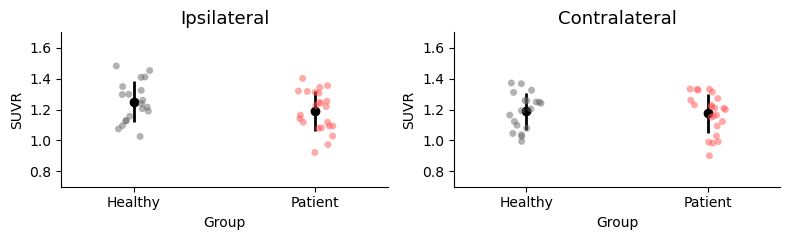

In [12]:
plot_mk6240_group_summary(slm_mixed, tauMK6240[df['sex'] == 'M',:], df[df['sex'] == 'M'], threshold=0.01)